## Introduction

The name of housing unit types are specific of the Italian market, therefore I create a short dictionary with its translation in English:
- Monolocale: studio flat(one-room apartment)
- Bilocale: two-rooms apartment       
- Trilocale: three-rooms apartment       
- Quadrilocale: four-rooms apartment
- Appartamento: flat/apartment (that is from four to more rooms) 
- Attico: attic           
- Villa: house/villa
- Palazzo: building/palace
- Mansarda: mansard        
- Loft: loft apartment       
- Terratetto: this is a typical italian building of the early year of the 20th century. It means "from the ground to the roof"      
- Open space: open space apartment  
- Casale: farmhouse

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math
import time

# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import  mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error

# from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

## Data Acquisition

In [ ]:
df_italia = pd.read_csv('D001_RAW_DATASET.csv')

In [5]:
df_italia.head()

,Index,Title description,Price,N_rooms,Surface,N_toilettes,Floor
0,1,"Appartamento via San Marco, Turati, Milano",8500.0,5+,250.0,3,3
1,2,"Monolocale via Benedetto Marcello, Buenos Aire...",1150.0,NaN,40.0,NaN,3
2,3,"Bilocale via Maddalena Donadoni Giudice 22, Bo...",900.0,2,51.0,NaN,3
3,4,"Bilocale via Larga 23, Missori, Milano",1550.0,2,55.0,NaN,3
4,5,"Bilocale via Giovanni Antonio Amadeo 40, Città...",920.0,2,45.0,NaN,3


In [10]:
df_italia.shape

(11395, 7)

### Feature engineering

In [11]:
# I create three new features City, Zone, and Housing unit from the original title description

df_italia['City'] = df_italia['Title description'].apply(lambda x: x.split()[-1])
df_italia['Zone'] = df_italia['Title description'].apply(lambda x: x.split(", ")[-2])

df_italia['Housing_unit'] = df_italia['Title description'].str.split(' ').str[0] 


In [12]:
df_italia.head()

,Index,Title description,Price,N_rooms,Surface,N_toilettes,Floor,City,Zone,Housing_unit
0,1,"Appartamento via San Marco, Turati, Milano",8500.0,5+,250.0,3,3,Milano,Turati,Appartamento
1,2,"Monolocale via Benedetto Marcello, Buenos Aire...",1150.0,NaN,40.0,NaN,3,Milano,Buenos Aires,Monolocale
2,3,"Bilocale via Maddalena Donadoni Giudice 22, Bo...",900.0,2,51.0,NaN,3,Milano,Bovisa,Bilocale
3,4,"Bilocale via Larga 23, Missori, Milano",1550.0,2,55.0,NaN,3,Milano,Missori,Bilocale
4,5,"Bilocale via Giovanni Antonio Amadeo 40, Città...",920.0,2,45.0,NaN,3,Milano,Città Studi,Bilocale


In [13]:
df_italia['City'].nunique(), df_italia['Zone'].nunique(), df_italia['Housing_unit'].nunique()

(20, 903, 19)

## Data Wrangling and Data Cleaning

In [14]:
df_italia.isnull().sum()

Index                   0
Title description       0
Price                 205
N_rooms              1372
Surface               190
N_toilettes          7519
Floor                  25
City                    0
Zone                    0
Housing_unit            0
dtype: int64

In [15]:
df_italia = df_italia[df_italia.Price.isnull()==False] #removed rows with Nan Price
df_italia.drop(columns = 'N_toilettes', inplace = True) #dropped N_toilettes becuase it is missing in 7519 rows on 11395
df_italia = df_italia[df_italia.Surface.isnull()==False]

In [16]:
df_italia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11001 entries, 0 to 205
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Index              11001 non-null  int64  
 1   Title description  11001 non-null  object 
 2   Price              11001 non-null  float64
 3   N_rooms            9772 non-null   object 
 4   Surface            11001 non-null  float64
 5   Floor              11000 non-null  object 
 6   City               11001 non-null  object 
 7   Zone               11001 non-null  object 
 8   Housing_unit       11001 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 859.5+ KB


In [17]:
df_italia.N_rooms.unique()

array(['5+', nan, '2', '4', '3', '5'], dtype=object)

In [18]:
df_italia[df_italia.N_rooms.isnull()==True].groupby('Housing_unit')['City'].count()
# 'Albergo', 'Cascina', 'Soffitta', 'Terratetto'

Housing_unit
Albergo            2
Appartamento      96
Attico            21
Cascina            1
Loft              18
Mansarda          34
Monolocale      1011
Open              11
Palazzo           26
Soffitta           1
Terratetto         3
Villa              5
Name: City, dtype: int64

In [19]:
df_italia.loc[(df_italia['Housing_unit']=='Monolocale') & (df_italia['N_rooms'].isnull()==True), 'N_rooms'] = 1

In [20]:
df_italia[df_italia.N_rooms.isnull()==True].groupby('Housing_unit')['City'].count()


Housing_unit
Albergo          2
Appartamento    96
Attico          21
Cascina          1
Loft            18
Mansarda        34
Open            11
Palazzo         26
Soffitta         1
Terratetto       3
Villa            5
Name: City, dtype: int64

In [21]:
df_italia = df_italia[df_italia.N_rooms.isnull()==False]

In [22]:
city_size = {
    "Roma": "big",
    "Milano": "big",
    "Napoli": "big",

    "Torino": "mid-big",
    "Palermo": "mid-big",
    "Genova": "mid-big",

    "Bologna": "mid",
    "Firenze": "mid",
    "Bari": "mid",
    "Catania": "mid",
    "Verona": "mid",
    "Venezia": "mid",
    "Messina": "mid",
    "Padova": "mid",
    "Trieste": "mid",
    "Brescia": "mid",
    "Taranto": "mid",
    "Prato": "mid",

    "Parma": "mid-small",
    "Modena": "mid-small"
}

df_italia["city_size"] = df_italia["City"].map(city_size)


#### Macroregion

In [23]:
city_macroregion = {
    "Milano": "north",
    "Torino": "north",
    "Genova": "north",
    "Bologna": "north",
    "Verona": "north",
    "Venezia": "north",
    "Padova": "north",
    "Trieste": "north",
    "Parma": "north",
    "Brescia": "north",
    "Modena": "north",

    "Prato": "center",
    "Roma": "center",
    "Firenze": "center",

    "Napoli": "south",
    "Palermo": "south",
    "Bari": "south",
    "Catania": "south",
    "Messina": "south",
    "Taranto": "south"
}


df_italia["macroregion"] = df_italia["City"].map(city_macroregion)


#### Zone

In [24]:
df_italia['Zone'].nunique() # it is a too granular data, I drop Zone to avoid overfitting in train

890

In [25]:
df_italia.drop(columns =['Index','Title description','Zone'], axis=1, inplace= True)

#### Housing_unit

In [26]:
df_italia['Housing_unit'].value_counts()

Housing_unit
Bilocale        3353
Trilocale       2652
Quadrilocale    1474
Appartamento    1397
Monolocale      1011
Attico           335
Villa            237
Palazzo          109
Mansarda          99
Loft              47
Terratetto        40
Albergo           10
Open               7
Casale             4
Loft,              3
Casa               3
Rustico            2
Name: count, dtype: int64

In [27]:
# Here, I fixed mistakes, aggregated into one when there were synonyms, 
# and deleted the element 'Albergo' (that is, Hotel) beacuse it is not a housing unit in which to live and so it is out of my research

df_italia["Housing_unit"] = df_italia["Housing_unit"].replace('Loft,', 'Loft')
df_italia["Housing_unit"] = df_italia["Housing_unit"].replace('Open', 'Open space')
df_italia["Housing_unit"] = df_italia["Housing_unit"].replace('Soffitta', 'Mansarda')
df_italia["Housing_unit"] = df_italia["Housing_unit"].replace(['Rustico', 'Cascina'], 'Casale')
df_italia["Housing_unit"] = df_italia["Housing_unit"].replace(['Casa'], 'Villa')
df_italia = df_italia[df_italia["Housing_unit"] != 'Albergo'] 


df_italia['Housing_unit'].value_counts()

Housing_unit
Bilocale        3353
Trilocale       2652
Quadrilocale    1474
Appartamento    1397
Monolocale      1011
Attico           335
Villa            240
Palazzo          109
Mansarda          99
Loft              50
Terratetto        40
Open space         7
Casale             6
Name: count, dtype: int64

#### Floor

In [28]:
df_italia['Floor'].unique() # we can see that some floor numbers are interger, while others are strings

array(['3', '15', '8', '5', '1', '2', '4', 'R', '0', '6', '7', '3 - 4',
       '1 - 2', '10', '4 - 5', '5 - 6', nan, 2, 6, 8, 0, 1, 3, 4, 5],
      dtype=object)

In [29]:
#I calculated the mode in order to replace NaN values
df_italia["Floor"].mode()

0    1
Name: Floor, dtype: object

In [30]:
mapping = {'3': 3.0,
            '15': 15.0, 
            '8': 8.0, 
            '5': 5.0, 
            '1': 1.0, 
            '2': 2.0, 
            '4': 4.0, 
            'R': 0.5, 
            '0': 0.0, 
            '6': 6.0, 
            '7': 7.0, 
            '3 - 4': 4.0,
            '1 - 2' : 2.0, 
            '10': 10.0, 
            '4 - 5': 5.0, 
            '5 - 6': 6.0, 
            'nan': 1.0, 
            2 : 2.0, 
            6 : 6.0, 
            8 : 8.0, 
            0 : 0.0, 
            1 : 1.0, 
            3 : 3.0, 
            4 : 4.0, 
            5 : 5.0
            }


df_italia['floor'] = df_italia['Floor'].map(mapping)
df_italia.drop('Floor', axis = 1, inplace = True)


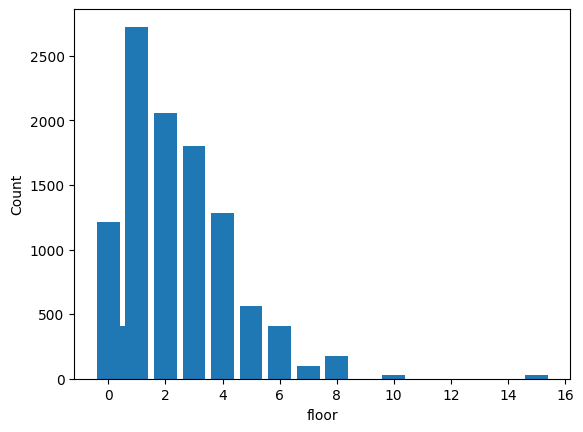

In [32]:
df_floor = df_italia['floor'].value_counts().reset_index().sort_values(by = 'floor', ascending  = True)

plt.bar(df_floor['floor'], df_floor['count'])
plt.xlabel("floor")
plt.ylabel("Count");


#### N_rooms

In [33]:
housing_to_rooms = {
    'Monolocale': '1',
    'Appartamento': '5',
    'Attico': '3',
    'Casale': '3',
    'Loft': '2',
    'Mansarda': '2',
    'Open space': '2',
    'Palazzo': '5+',
    'Terratetto': '5+',
    'Villa': '5+'
}

df_italia['N_rooms'] = df_italia['N_rooms'].fillna(
    df_italia['Housing_unit'].map(housing_to_rooms)
)


In [34]:
mapping = {
                1: 1, 
                '2': 2, 
                '3': 3, 
                '4': 4, 
                '5': 5,
                '5+': 6
            }

df_italia['num_rooms'] = df_italia['N_rooms'].map(mapping)
df_italia.drop('N_rooms', axis = 1, inplace = True)

In [35]:
df_italia

,Price,Surface,City,Housing_unit,city_size,macroregion,floor,num_rooms
0,8500.0,250.0,Milano,Appartamento,big,north,3.0,6
1,1150.0,40.0,Milano,Monolocale,big,north,3.0,1
2,900.0,51.0,Milano,Bilocale,big,north,3.0,2
3,1550.0,55.0,Milano,Bilocale,big,north,3.0,2
4,920.0,45.0,Milano,Bilocale,big,north,3.0,2
...,...,...,...,...,...,...,...,...
201,1500.0,140.0,Modena,Attico,mid-small,north,4.0,4
202,600.0,25.0,Modena,Bilocale,mid-small,north,4.0,2
203,850.0,70.0,Modena,Bilocale,mid-small,north,4.0,2
204,450.0,16.0,Modena,Monolocale,mid-small,north,4.0,1


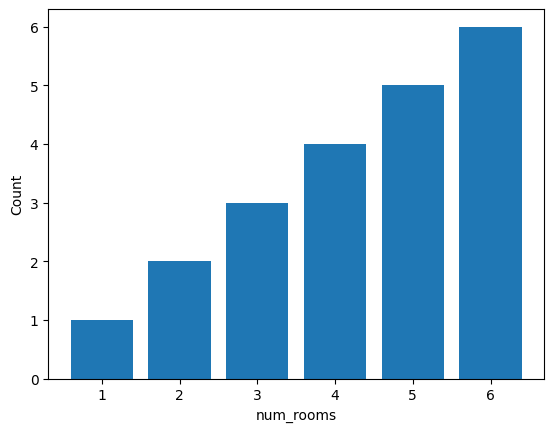

In [36]:
df_rooms = df_italia['num_rooms'].value_counts().reset_index().sort_values(by = 'num_rooms', ascending  = True)

plt.bar(df_rooms['num_rooms'], df_rooms['num_rooms'])
plt.xlabel("num_rooms")
plt.ylabel("Count");


In [37]:
df_italia.isnull().sum()

Price           0
Surface         0
City            0
Housing_unit    0
city_size       0
macroregion     0
floor           1
num_rooms       0
dtype: int64

#### Price

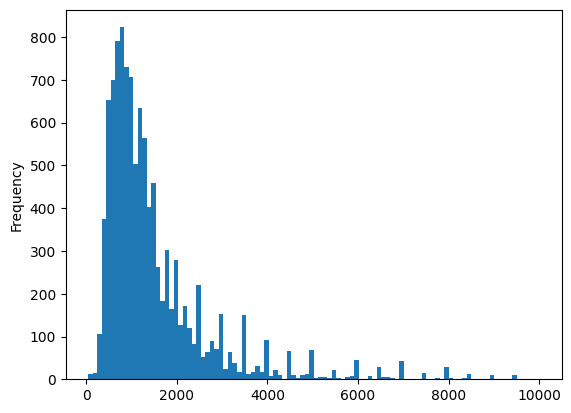

In [38]:
df_italia.Price.plot(kind = 'hist', bins = 100);

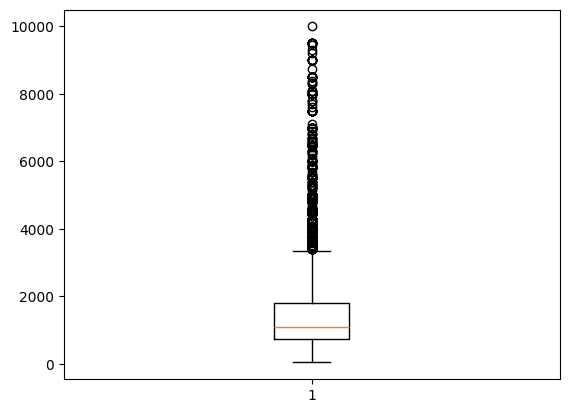

In [39]:
# df_italia.Price.plot(kind = 'boxplot');
plt.boxplot(df_italia['Price']);


In [40]:

bins = [-float("inf"), 450, 700, 1000, 2000, 4000, float("inf")]
labels = [
    "very low",
    "low",
    "mid-low",
    "mid-high",
    "high",
    "very high"
]

df_italia["rent_bracket"] = pd.cut(
    df_italia["Price"],
    bins=bins,
    labels=labels,
    right=False
)


In [41]:
df_italia["rent_bracket"] = pd.Categorical(
    df_italia["rent_bracket"],
    categories=labels,
    ordered=True
)


In [42]:
df_italia

,Price,Surface,City,Housing_unit,city_size,macroregion,floor,num_rooms,rent_bracket
0,8500.0,250.0,Milano,Appartamento,big,north,3.0,6,very high
1,1150.0,40.0,Milano,Monolocale,big,north,3.0,1,mid-high
2,900.0,51.0,Milano,Bilocale,big,north,3.0,2,mid-low
3,1550.0,55.0,Milano,Bilocale,big,north,3.0,2,mid-high
4,920.0,45.0,Milano,Bilocale,big,north,3.0,2,mid-low
...,...,...,...,...,...,...,...,...,...
201,1500.0,140.0,Modena,Attico,mid-small,north,4.0,4,mid-high
202,600.0,25.0,Modena,Bilocale,mid-small,north,4.0,2,low
203,850.0,70.0,Modena,Bilocale,mid-small,north,4.0,2,mid-low
204,450.0,16.0,Modena,Monolocale,mid-small,north,4.0,1,low


#### Surface

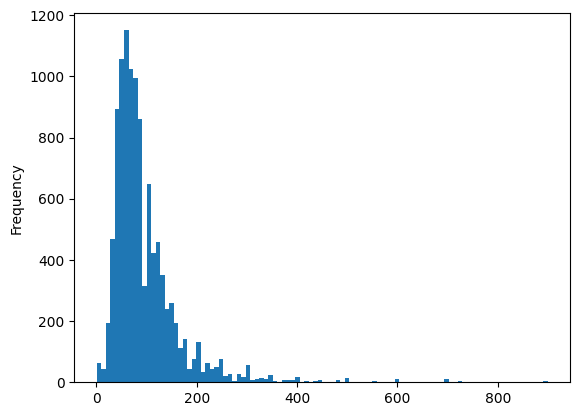

In [43]:
df_italia.Surface.plot(kind = 'hist', bins = 100);

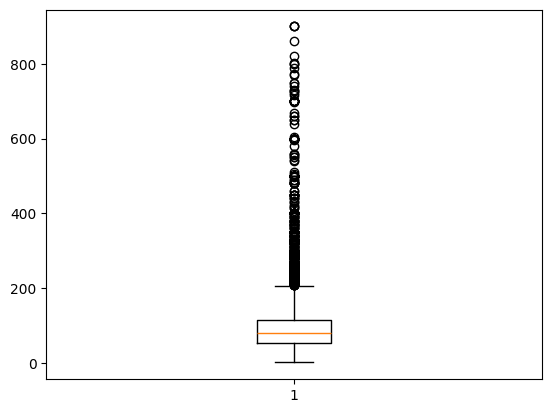

In [44]:
plt.boxplot(df_italia['Surface']);


In [45]:
df_italia = df_italia[~(df_italia['Surface']<20)]

In [46]:

bins = [-np.inf, 40, 70, 100, 200, 400, np.inf]
labels = [
    "very small",
    "small",
    "mid-small",
    "mid",
    "large",
    "very large"
]

df_italia["surface_bracket"] = pd.cut(
    df_italia["Surface"],
    bins=bins,
    labels=labels,
    right=False
)


In [47]:
df_italia["surface_bracket"] = pd.Categorical(
    df_italia["surface_bracket"],
    categories=labels,
    ordered=True
)


# Fai una combo di queste quattro feature per irrubustire il pattern

In [48]:
df_italia.groupby(['city_size', 'macroregion', 'rent_bracket', 'surface_bracket'])['num_rooms'].count().reset_index().sort_values(by="num_rooms", ascending =False)

,city_size,macroregion,rent_bracket,surface_bracket,num_rooms
55,big,north,mid-high,small,612
259,mid-big,north,low,small,418
21,big,center,mid-high,mid,312
63,big,north,high,mid,290
56,big,north,mid-high,mid-small,281
...,...,...,...,...,...
53,big,north,mid-low,very large,0
5,big,center,very low,very large,0
60,big,north,high,very small,0
352,mid-small,center,high,large,0


## Explanatory Data Analysis

In [49]:
df_italia.head()

,Price,Surface,City,Housing_unit,city_size,macroregion,floor,num_rooms,rent_bracket,surface_bracket
0,8500.0,250.0,Milano,Appartamento,big,north,3.0,6,very high,large
1,1150.0,40.0,Milano,Monolocale,big,north,3.0,1,mid-high,small
2,900.0,51.0,Milano,Bilocale,big,north,3.0,2,mid-low,small
3,1550.0,55.0,Milano,Bilocale,big,north,3.0,2,mid-high,small
4,920.0,45.0,Milano,Bilocale,big,north,3.0,2,mid-low,small


#### Price

##### Observations:

- The average rent price is 1496€ per month, while the median value is 1100€.
- Most of the prices are below the 2,000€ per month, while a small percentange is above this threshold until picks between 8,000 and 10,000€ per month.
- The distribution of prices is left skewed.
- The most expensive housing units are avereagly: Villa, Palazzo, Attico, Terratetto and Appartamento; while the cheapest are Monolocale, Mansarda and Bilocale.
- Florence, Milan and Rome have the highest average rent price.
- The price was analyzed in relation with the five most frequent types of housing units: Monolocale, Bilocale, Trilocale, Quadrilocale, Appartmento.
- It emerged that the most costly are Appartamento and Quadrilocale, probably because they have the more rooms and a larger surface, followed by Trilocale. The cheapest are Monolocale and Bilocale.

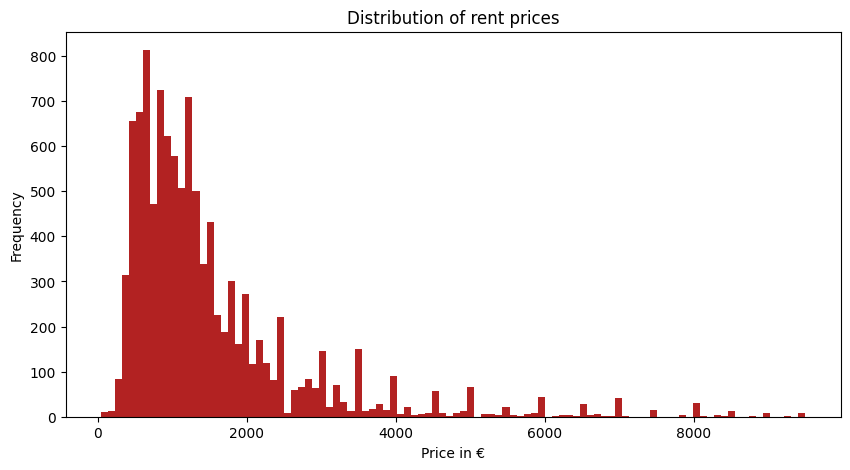

In [50]:
plt.figure(figsize=(10,5))
plt.title('Distribution of rent prices')
plt.hist(df_italia['Price'], bins = 100, color = 'firebrick')
plt.xlabel('Price in €')
plt.ylabel('Frequency');

In [51]:
df_italia['Price'].mean(), df_italia['Price'].median()

(np.float64(1506.6796662604293), np.float64(1100.0))

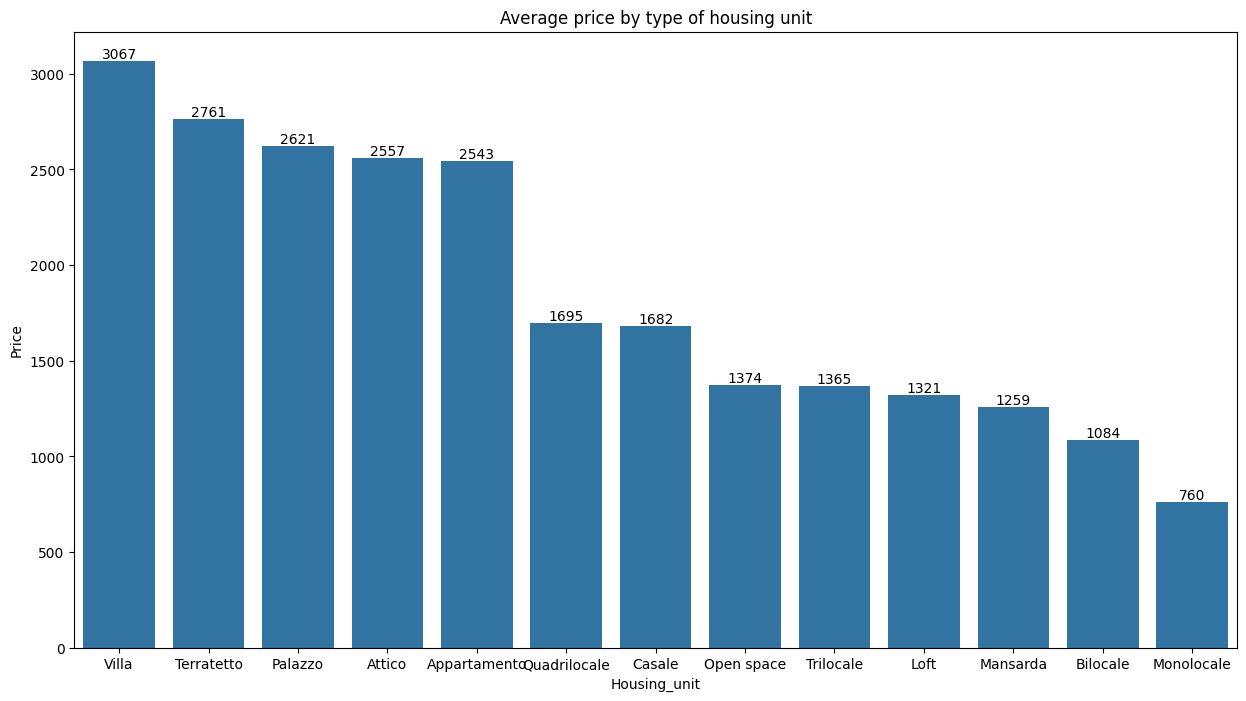

In [52]:
df_price = df_italia[['Housing_unit','Price']].groupby(['Housing_unit'])['Price'].mean().sort_values(ascending = False).round().reset_index()

plt.figure(figsize=(15, 8))
fig = sns.barplot(data = df_price, x = 'Housing_unit', y = 'Price')
plt.bar_label(fig.containers[0])
plt.title('Average price by type of housing unit');

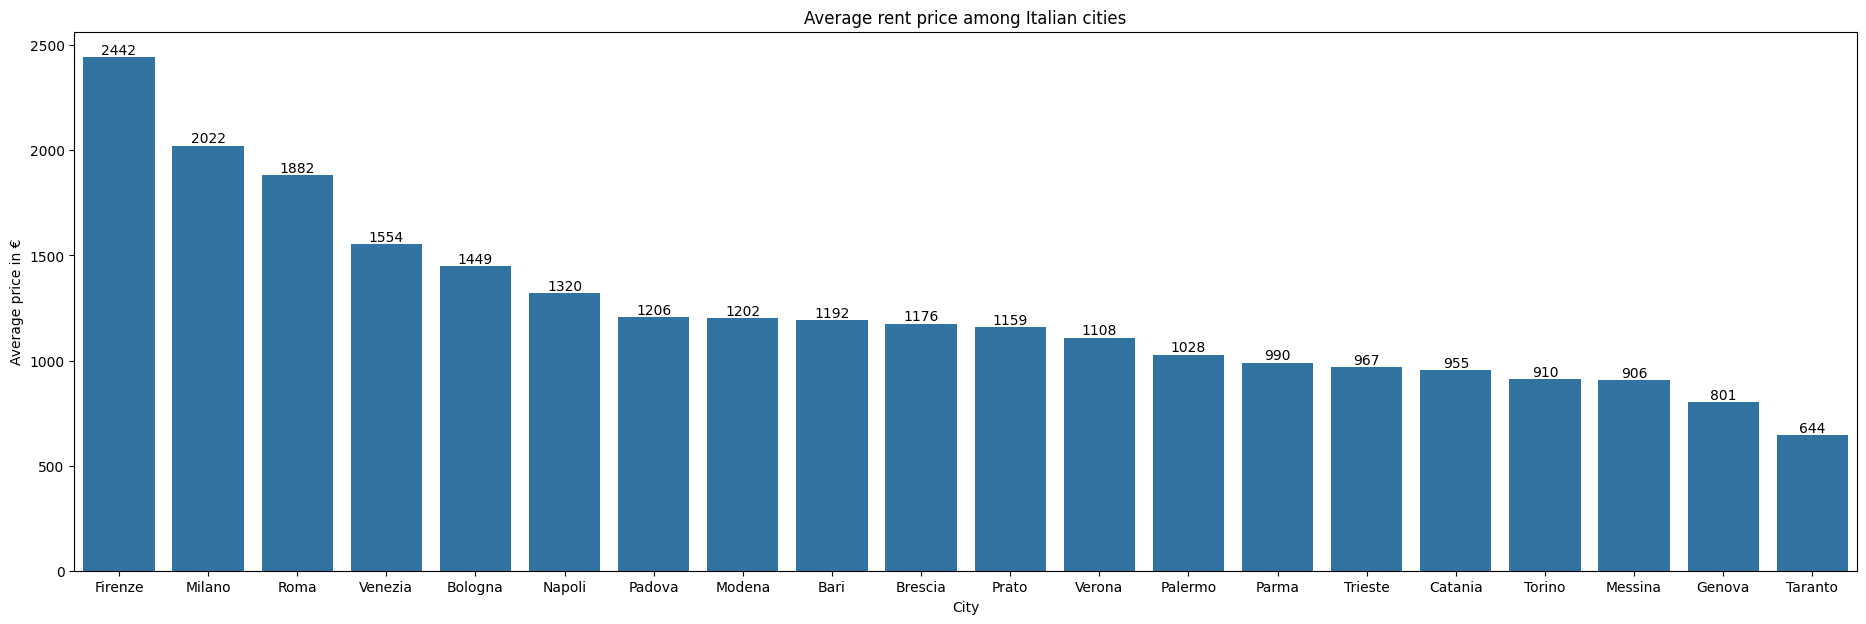

In [53]:
df_avg_price = df_italia[['City', 'Price']].groupby(['City'])['Price'].mean().sort_values(ascending = False).reset_index().round()

ax = plt.subplots(figsize=(23, 7))
splot = sns.barplot(data = df_avg_price, x = 'City', y = 'Price', ci = None)
plt.bar_label(splot.containers[0])
plt.title('Average rent price among Italian cities')
plt.ylabel('Average price in €');

In [54]:
df_housing_unit_filtered = df_italia[((df_italia.Housing_unit == 'Monolocale') | (df_italia.Housing_unit == 'Bilocale') | (df_italia.Housing_unit == 'Trilocale') |
                      (df_italia.Housing_unit == 'Quadrilocale') | (df_italia.Housing_unit == 'Appartamento')) &
                      ((df_italia.City == 'Roma') | (df_italia.City == 'Milano') | (df_italia.City == 'Torino') |
                      (df_italia.City == 'Firenze') | (df_italia.City == 'Bologna') | 
                      (df_italia.City == 'Genova') | (df_italia.City == 'Napoli') | (df_italia.City == 'Palermo'))]

df_housing_unit_filtered = df_housing_unit_filtered.round()
df_housing_unit_filtered.head()

,Price,Surface,City,Housing_unit,city_size,macroregion,floor,num_rooms,rent_bracket,surface_bracket
0,8500.0,250.0,Milano,Appartamento,big,north,3.0,6,very high,large
1,1150.0,40.0,Milano,Monolocale,big,north,3.0,1,mid-high,small
2,900.0,51.0,Milano,Bilocale,big,north,3.0,2,mid-low,small
3,1550.0,55.0,Milano,Bilocale,big,north,3.0,2,mid-high,small
4,920.0,45.0,Milano,Bilocale,big,north,3.0,2,mid-low,small


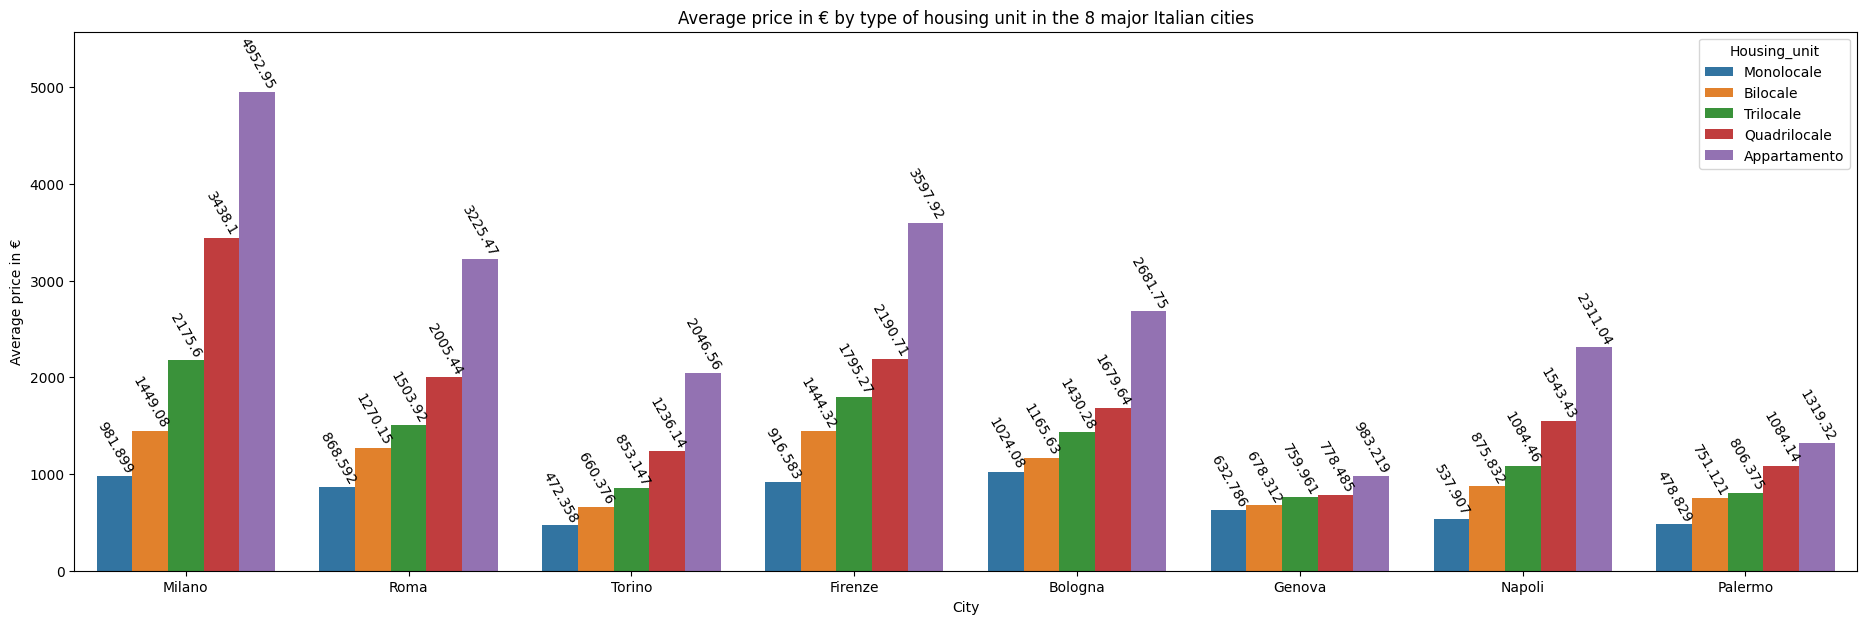

In [55]:
fig, ax = plt.subplots(figsize=(23, 7))
labels_ordered = ['Monolocale','Bilocale','Trilocale', 'Quadrilocale','Appartamento']
cities_ordered = ['Milano','Roma', 'Torino', 'Firenze', 'Bologna', 'Genova', 'Napoli', 'Palermo']
splot = sns.barplot(data = df_housing_unit_filtered, x = 'City', y = 'Price', hue = 'Housing_unit', order = cities_ordered, hue_order = labels_ordered , ax = ax, ci=None)
ax.bar_label(splot.containers[0], rotation=300)
ax.bar_label(splot.containers[1], rotation=300)
ax.bar_label(splot.containers[2], rotation=300)
ax.bar_label(splot.containers[3], rotation=300)
ax.bar_label(splot.containers[4], rotation=300)
plt.margins(y = 0.125)
plt.title('Average price in € by type of housing unit in the 8 major Italian cities')
plt.ylabel('Average price in €');

#### Surface

##### Observations:

- The average surface is 97 m², while the median value is 78 m².
- The cities with the highest average surface are Firenza, Catania and Roma, while those with the lowest are Torino, Bologna, and Trieste
- The housing unit type with the largest average surface are Villa, Terratetto and Appartamento, while those with the lowest are Monolocale, Bilocale and Mansarda.

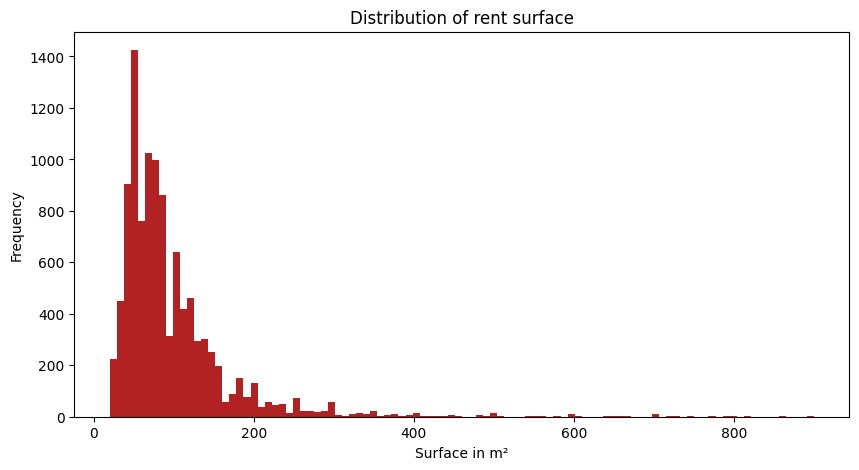

In [56]:
plt.figure(figsize=(10,5))
plt.title('Distribution of rent surface')
plt.hist(df_italia['Surface'], bins = 100, color = 'firebrick')
plt.xlabel('Surface in m²')
plt.ylabel('Frequency');

In [57]:
round(df_italia['Surface'].mean(),0), df_italia['Surface'].median()

(np.float64(98.0), np.float64(80.0))

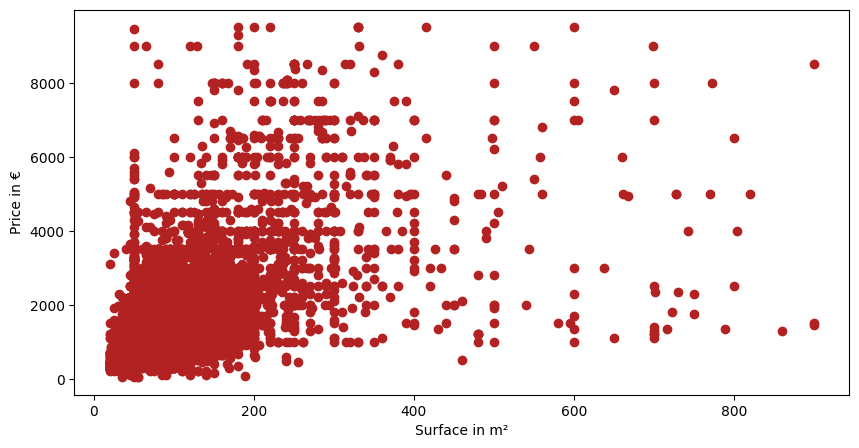

In [58]:
plt.figure(figsize=(10,5))
plt.scatter(df_italia['Surface'],df_italia['Price'], color = 'firebrick')
plt.xlabel('Surface in m²')
plt.ylabel('Price in €');

In [59]:
df_avg_surface_city = df_italia[['City','Surface']].groupby(['City'])['Surface'].mean().sort_values(ascending=False).reset_index()

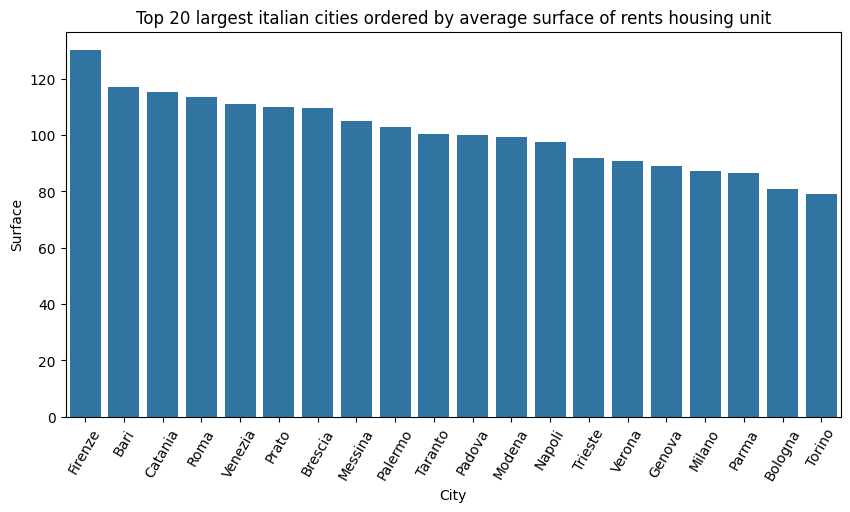

In [60]:
plt.figure(figsize=(10,5))
sns.barplot(data = df_avg_surface_city, x = 'City', y = 'Surface')
plt.xticks(rotation = 60)
plt.title('Top 20 largest italian cities ordered by average surface of rents housing unit');

In [61]:
df_avg_surface_housing_unit = round(df_italia[['City', 'Housing_unit', 'Surface']].groupby(['Housing_unit'])['Surface'].mean().sort_values(ascending=False).reset_index(),0)
df_avg_surface_housing_unit

,Housing_unit,Surface
0,Palazzo,310.0
1,Villa,293.0
2,Terratetto,223.0
3,Appartamento,178.0
4,Casale,155.0
5,Attico,144.0
6,Quadrilocale,118.0
7,Trilocale,88.0
8,Open space,87.0
9,Mansarda,79.0


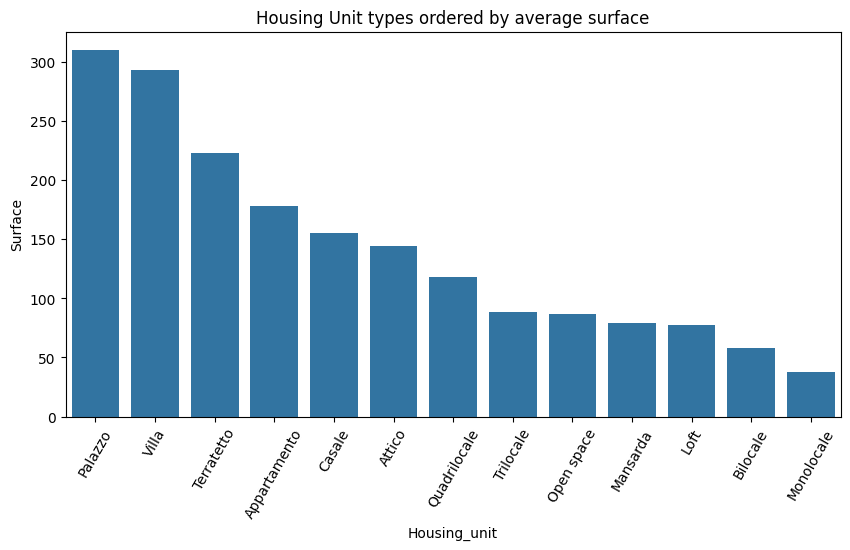

In [62]:
plt.figure(figsize=(10,5))
sns.barplot(data = df_avg_surface_housing_unit, x = 'Housing_unit', y = 'Surface')
plt.xticks(rotation = 60)
plt.title('Housing Unit types ordered by average surface');

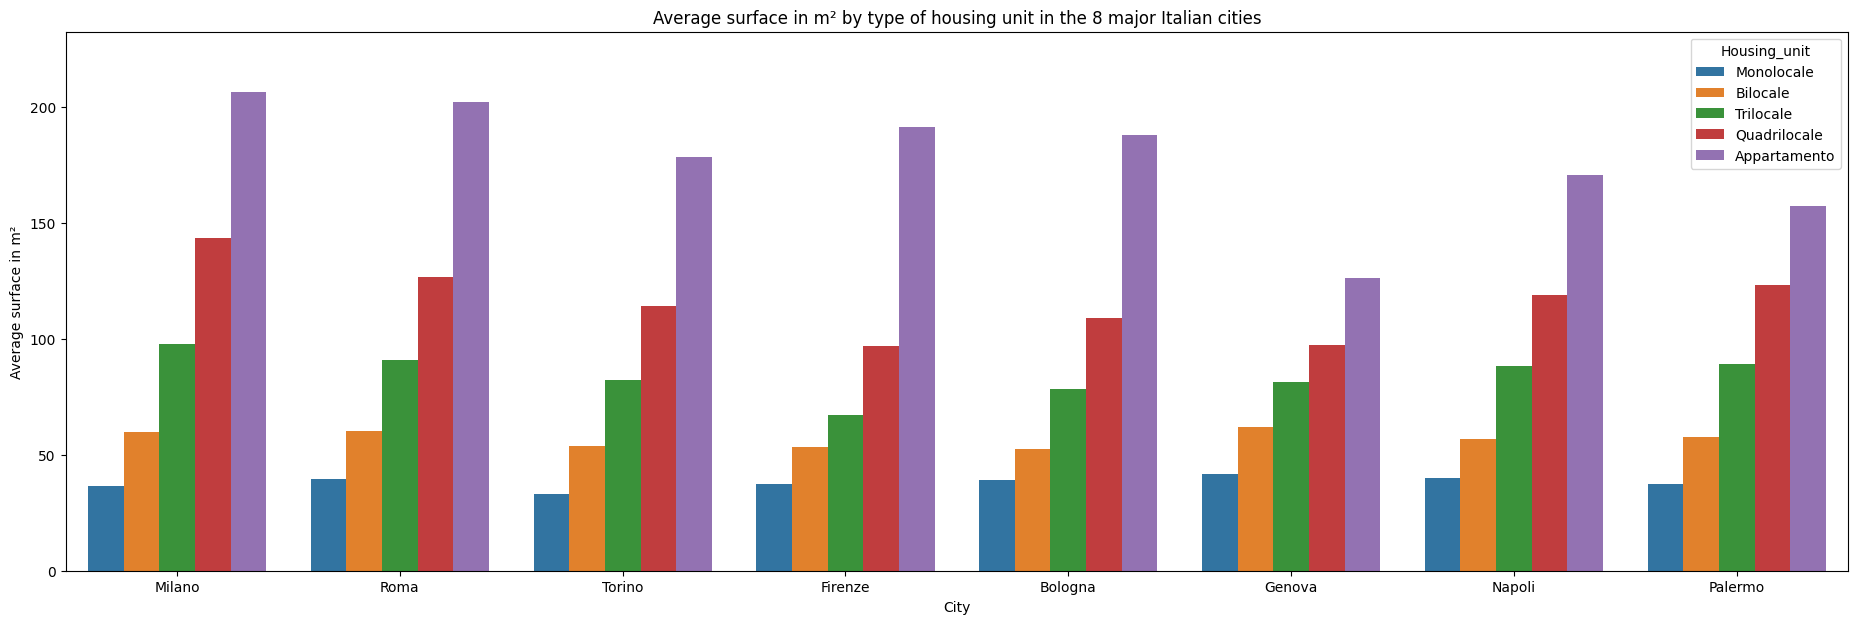

In [63]:
fig, ax = plt.subplots(figsize=(23, 7))
labels_ordered = ['Monolocale','Bilocale','Trilocale', 'Quadrilocale','Appartamento']
cities_ordered = ['Milano','Roma', 'Torino', 'Firenze', 'Bologna', 'Genova', 'Napoli', 'Palermo']
splot = sns.barplot(data = df_housing_unit_filtered, x = 'City', y = 'Surface', hue = 'Housing_unit', order = cities_ordered, hue_order = labels_ordered , ax = ax, ci=None)

plt.margins(y = 0.125)
plt.title('Average surface in m² by type of housing unit in the 8 major Italian cities')
plt.ylabel('Average surface in m²');

#### N_rooms

##### Observations:

- the most frequent number of rooms in a renting house: 2-rooms (3676), 3-rooms (2902), 4-rooms (1671) 

- Cities with most:
        
        - Monolocale-type flat: Torino(228), Milano(183), Bologna (161)
        
        - Bilocale-type flat: Milano (897), Torino (551), Roma (541)
        
        - Trilocale-type flat: Milano (515), Roma (512), Torino (352)
        
        - Quadrilocale-type flat: Roma (261), Milano (172), Torino (162)
        
        - Apartments: Roma (269), Firenze (263), Torino(164), Genova (163)

In [65]:
rooms = df_italia.groupby(['num_rooms']).size().reset_index().rename(columns = {0: 'Num'})
rooms

,num_rooms,Num
0,1,979
1,2,3520
2,3,2827
3,4,1618
4,5,826
5,6,897


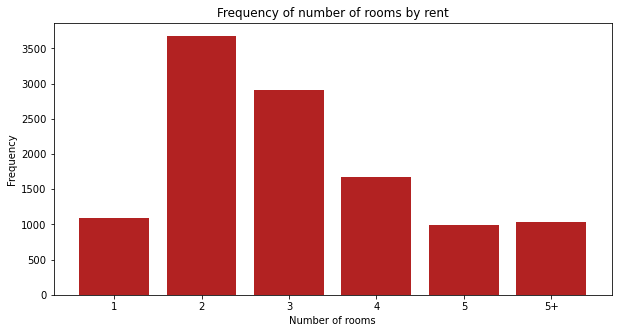

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Frequency of number of rooms by rent')
fig = plt.bar(rooms['N_rooms'], rooms['Num'], color = 'firebrick')

plt.xlabel('Number of rooms')
plt.ylabel('Frequency');

In [66]:
# Here, I found the most frequent number of rooms by city
df_italia[['City','num_rooms']].groupby(['City'])['num_rooms'].agg(pd.Series.mode)

City
Bari       2
Bologna    2
Brescia    3
Catania    2
Firenze    6
Genova     3
Messina    3
Milano     2
Modena     4
Napoli     2
Padova     2
Palermo    2
Parma      2
Prato      2
Roma       2
Taranto    3
Torino     2
Trieste    2
Venezia    3
Verona     2
Name: num_rooms, dtype: int64

In [67]:
df_monolocali = df_italia[df_italia['Housing_unit']=='Monolocale']
df_monolocali[['City','num_rooms']].groupby(['City'])['num_rooms'].count().sort_values(ascending = False).reset_index().head(5)

,City,num_rooms
0,Torino,204
1,Milano,178
2,Bologna,146
3,Roma,130
4,Firenze,48


In [68]:
df_bilocali = df_italia[df_italia['Housing_unit']=='Bilocale']
df_bilocali[['City','num_rooms']].groupby(['City'])['num_rooms'].count().sort_values(ascending = False).reset_index().head(5)

,City,num_rooms
0,Milano,895
1,Roma,537
2,Torino,534
3,Bologna,229
4,Genova,170


In [69]:
df_trilocali = df_italia[df_italia['Housing_unit']=='Trilocale']
df_trilocali[['City','num_rooms']].groupby(['City'])['num_rooms'].count().sort_values(ascending = False).reset_index().head(5)

,City,num_rooms
0,Milano,512
1,Roma,508
2,Torino,346
3,Bologna,198
4,Genova,178


In [70]:
df_trilocali = df_italia[df_italia['Housing_unit']=='Trilocale']
df_trilocali[['City','num_rooms']].groupby(['City'])['num_rooms'].count().sort_values(ascending = False).reset_index().head(5)

,City,num_rooms
0,Milano,512
1,Roma,508
2,Torino,346
3,Bologna,198
4,Genova,178


In [71]:
df_locals = df_italia[['City','Housing_unit','num_rooms']].groupby(['Housing_unit','City'])['num_rooms'].count().reset_index()

df_locals = df_locals[((df_locals.Housing_unit == 'Monolocale') | (df_locals.Housing_unit == 'Bilocale') | (df_locals.Housing_unit == 'Trilocale') |
                      (df_locals.Housing_unit == 'Quadrilocale') | (df_locals.Housing_unit == 'Appartamento')) &
                      ((df_locals.City == 'Roma') | (df_locals.City == 'Milano') | (df_locals.City == 'Torino') |
                      (df_locals.City == 'Firenze') | (df_locals.City == 'Bologna') | 
                      (df_locals.City == 'Genova') | (df_locals.City == 'Napoli') | (df_locals.City == 'Palermo'))]
df_locals.head(5)

,Housing_unit,City,num_rooms
1,Appartamento,Bologna,63
4,Appartamento,Firenze,231
5,Appartamento,Genova,160
7,Appartamento,Milano,102
9,Appartamento,Napoli,100


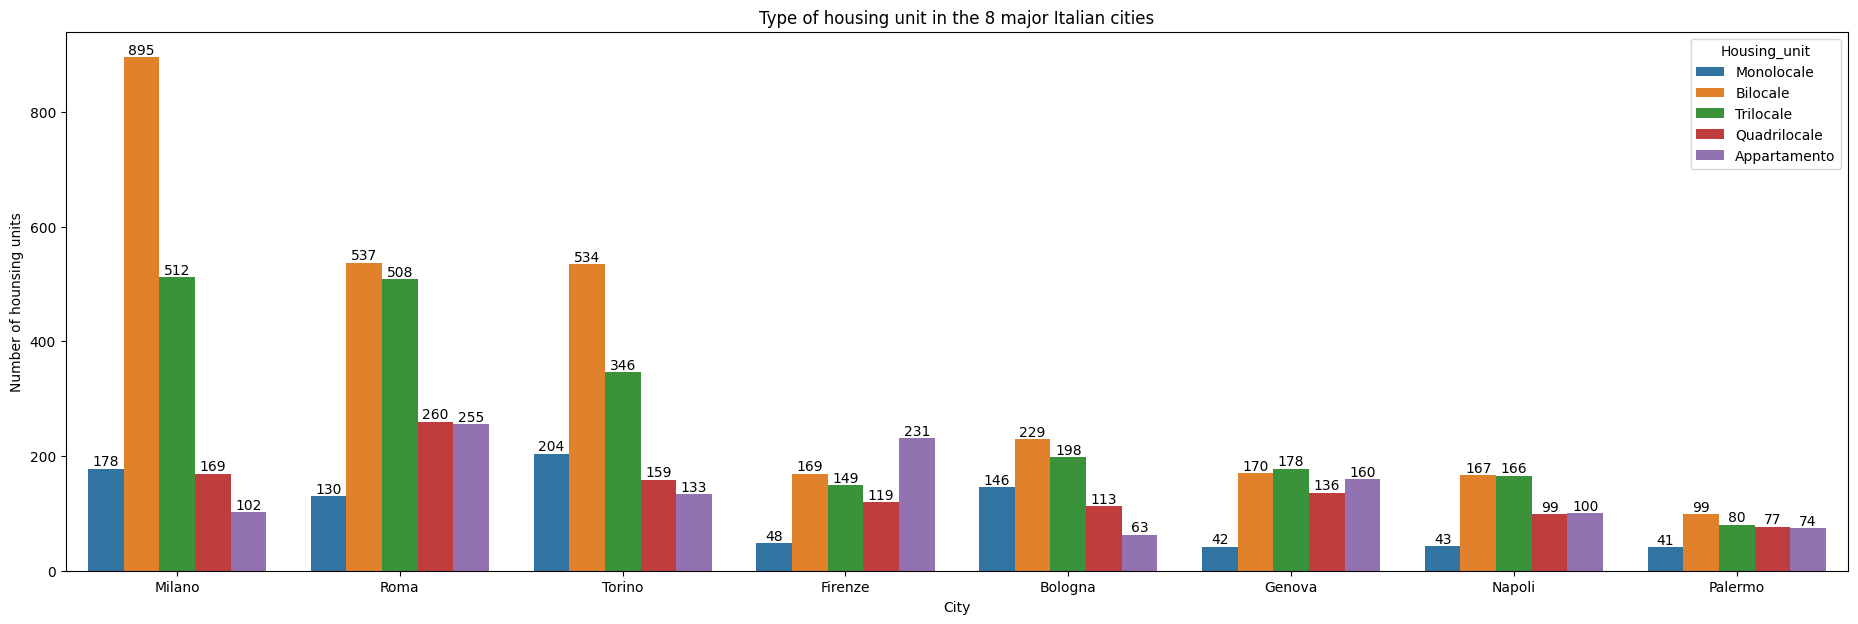

In [72]:
fig, ax = plt.subplots(figsize=(23, 7))
labels_ordered = ['Monolocale','Bilocale','Trilocale', 'Quadrilocale','Appartamento']
cities_ordered = ['Milano','Roma', 'Torino', 'Firenze', 'Bologna', 'Genova', 'Napoli', 'Palermo']
splot = sns.barplot(data = df_locals, x = 'City', y = 'num_rooms', hue = 'Housing_unit', order = cities_ordered, hue_order = labels_ordered , ax = ax)
plt.bar_label(splot.containers[0])
plt.bar_label(splot.containers[1])
plt.bar_label(splot.containers[2])
plt.bar_label(splot.containers[3])
plt.bar_label(splot.containers[4])
plt.title('Type of housing unit in the 8 major Italian cities')
plt.ylabel('Number of hounsing units');

#### City

##### Observations:

- The cities with most announcements on Immobiliare.it are Roma, Milano, and Torino; while those the less announcements are Prato, Taranto, and Bari
- The cities with the most expansive average rent price are Firenze, Milano, and Roma; while those with the lowest are Taranto, Genova, Messina

In [73]:
city = df_italia.groupby(['City']).size().sort_values(ascending = False).reset_index().rename(columns = {0: 'Num'})
city

,City,Num
0,Milano,1945
1,Roma,1937
2,Torino,1470
3,Firenze,829
4,Bologna,783
5,Genova,706
6,Napoli,604
7,Palermo,408
8,Parma,255
9,Venezia,250


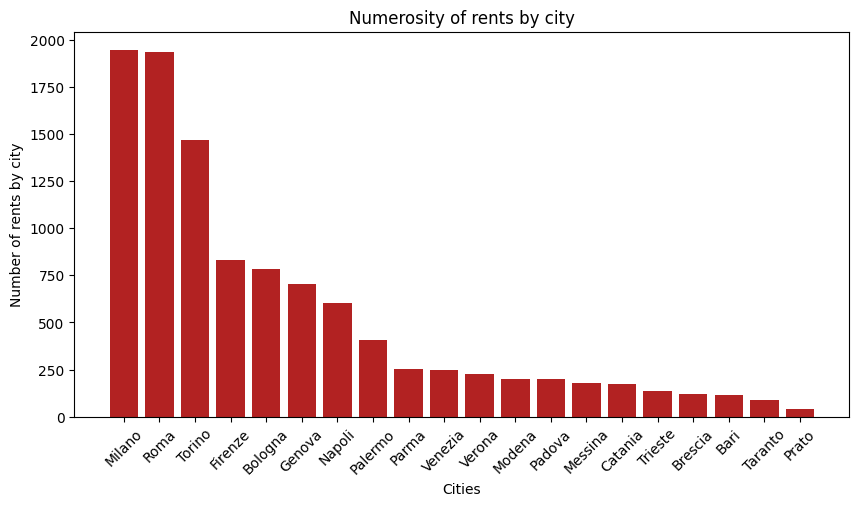

In [74]:
plt.figure(figsize=(10,5))
plt.title('Numerosity of rents by city')
fig = plt.bar(city['City'], city['Num'], color = 'firebrick')
plt.xlabel('Cities')
plt.ylabel('Number of rents by city')
plt.xticks(rotation = 45);

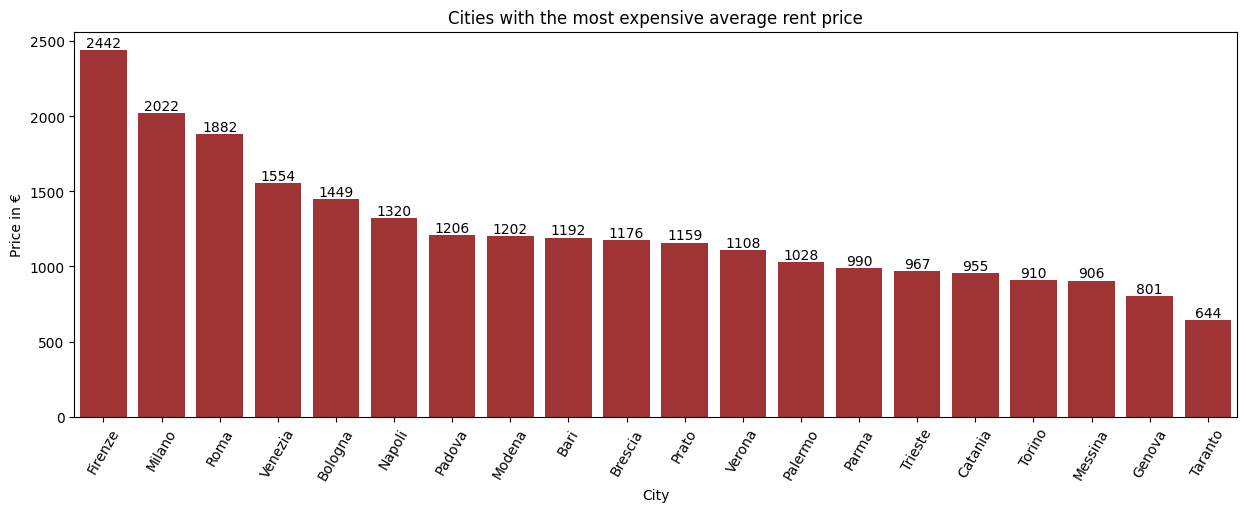

In [75]:
df_most_expensive_cities = df_italia[['City','Price']].groupby(['City'])['Price'].mean().round().reset_index().sort_values(by ='Price', ascending=False)

plt.figure(figsize=(15,5))
fig = sns.barplot(data = df_most_expensive_cities, x='City', y='Price', color='firebrick')
plt.bar_label(fig.containers[0])
plt.title('Cities with the most expensive average rent price')
plt.ylabel('Price in €')
plt.xticks(rotation = 60);

#### Housing_unit

Here, there are some graphs that are specific for the variable Housing_unit but that have been already analyzed above

In [76]:
N_types_of_locals = df_italia.groupby(['Housing_unit']).size().sort_values(ascending = False).reset_index().rename(columns={0:'Num'})
N_types_of_locals

,Housing_unit,Num
0,Bilocale,3342
1,Trilocale,2652
2,Quadrilocale,1473
3,Appartamento,1390
4,Monolocale,979
5,Attico,335
6,Villa,234
7,Mansarda,99
8,Palazzo,60
9,Loft,50


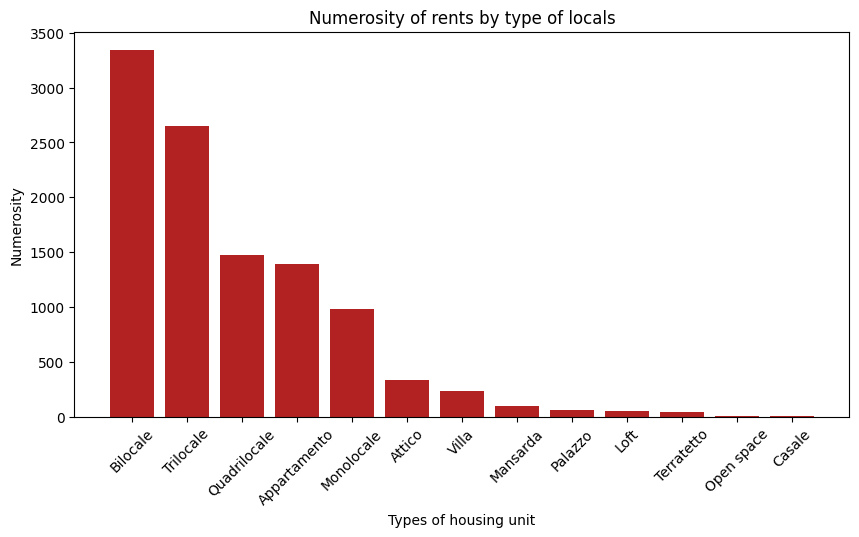

In [77]:
plt.figure(figsize=(10,5))
plt.title('Numerosity of rents by type of locals')
plt.bar(N_types_of_locals['Housing_unit'], N_types_of_locals['Num'], color = 'firebrick')
plt.xlabel('Types of housing unit')
plt.ylabel('Numerosity')
plt.xticks(rotation = 45);

In [78]:
df_italia1 = df_italia[['City', 'Housing_unit','num_rooms']].groupby(['City','Housing_unit'])['num_rooms'].count().sort_values(ascending = False).reset_index()

df1 = df_italia1[(df_italia1['Housing_unit']=='Appartamento') | (df_italia1['Housing_unit']=='Monolocale') | (df_italia1['Housing_unit']=='Bilocale') |
                (df_italia1['Housing_unit']=='Trilocale') | (df_italia1['Housing_unit']=='Quadrilocale')]

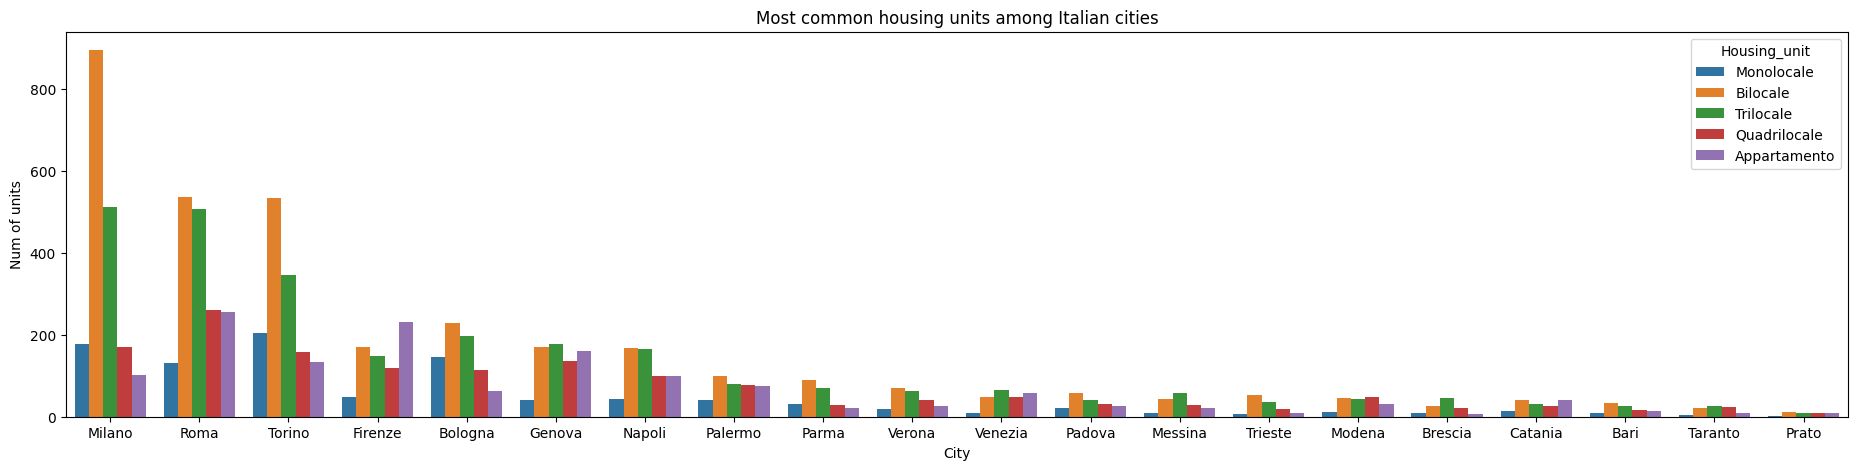

In [79]:
plt.figure(figsize=(23,5))
labels = ['Monolocale', 'Bilocale', 'Trilocale', 'Quadrilocale','Appartamento']
plt.legend(labels =['Monolocale', 'Bilocale', 'Trilocale', 'Quadrilocale','Appartamento'], loc=1)
sns.barplot(data = df1, x = 'City', y = 'num_rooms', hue = 'Housing_unit', hue_order = labels)
plt.title('Most common housing units among Italian cities')
plt.ylabel('Num of units');

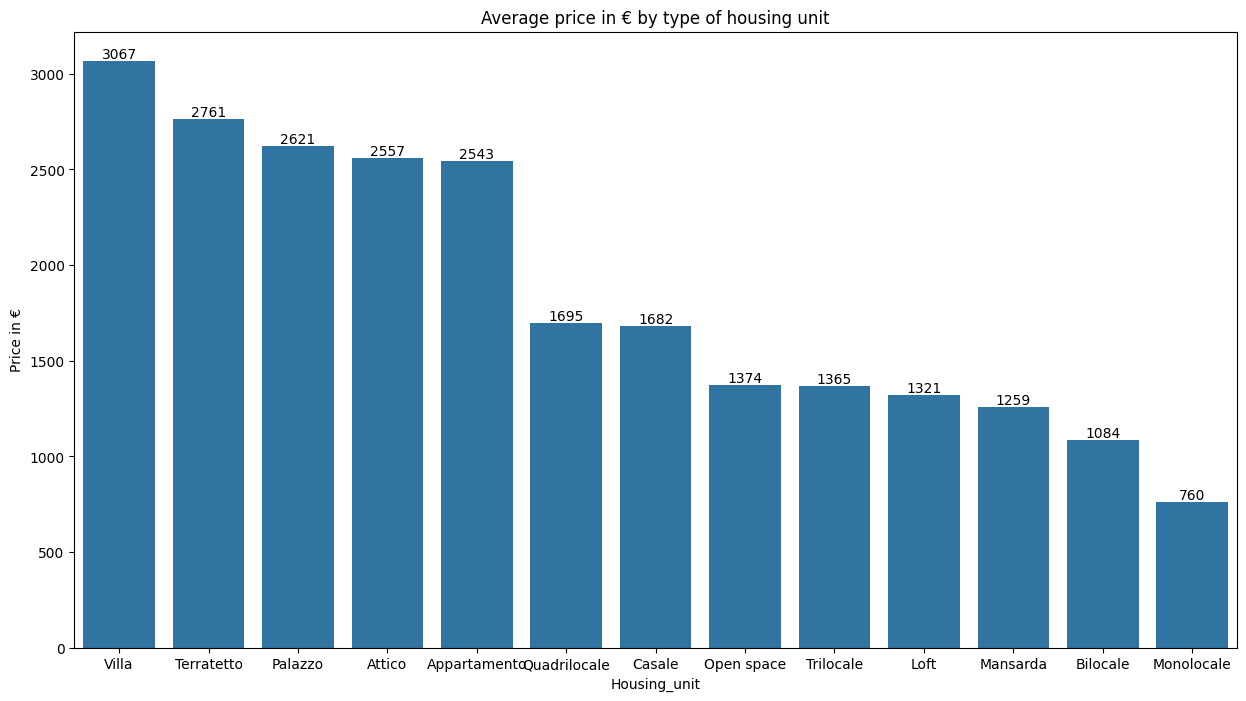

In [80]:
df_price = df_italia[['Housing_unit','Price']].groupby(['Housing_unit'])['Price'].mean().sort_values(ascending = False).round().reset_index()

plt.figure(figsize=(15, 8))
fig = sns.barplot(data = df_price, x = 'Housing_unit', y = 'Price')
plt.bar_label(fig.containers[0])
plt.ylabel('Price in €')
plt.title('Average price in € by type of housing unit');

In [81]:
df_monolocali = df_italia[df_italia['Housing_unit']=='Monolocale']
df_monolocali[['City','num_rooms']].groupby(['City'])['num_rooms'].size().sort_values(ascending = False).reset_index().head(5)

,City,num_rooms
0,Torino,204
1,Milano,178
2,Bologna,146
3,Roma,130
4,Firenze,48


In [82]:
df_bilocali = df_italia[df_italia['Housing_unit']=='Bilocale']
df_bilocali[['City','num_rooms']].groupby(['City'])['num_rooms'].size().sort_values(ascending = False).reset_index().head(5)

,City,num_rooms
0,Milano,895
1,Roma,537
2,Torino,534
3,Bologna,229
4,Genova,170


In [83]:
df_trilocali = df_italia[df_italia['Housing_unit']=='Trilocale']
df_trilocali[['City','num_rooms']].groupby(['City'])['num_rooms'].size().sort_values(ascending = False).reset_index().head(5)

,City,num_rooms
0,Milano,512
1,Roma,508
2,Torino,346
3,Bologna,198
4,Genova,178


In [84]:
df_quadrilocali = df_italia[df_italia['Housing_unit']=='Quadrilocale']
df_quadrilocali[['City','num_rooms']].groupby(['City'])['num_rooms'].size().sort_values(ascending = False).reset_index().head(5)

,City,num_rooms
0,Roma,260
1,Milano,169
2,Torino,159
3,Genova,136
4,Firenze,119


## CREATE FINAL DATASET

In [85]:
df_italia

,Price,Surface,City,Housing_unit,city_size,macroregion,floor,num_rooms,rent_bracket,surface_bracket
0,8500.0,250.0,Milano,Appartamento,big,north,3.0,6,very high,large
1,1150.0,40.0,Milano,Monolocale,big,north,3.0,1,mid-high,small
2,900.0,51.0,Milano,Bilocale,big,north,3.0,2,mid-low,small
3,1550.0,55.0,Milano,Bilocale,big,north,3.0,2,mid-high,small
4,920.0,45.0,Milano,Bilocale,big,north,3.0,2,mid-low,small
...,...,...,...,...,...,...,...,...,...,...
200,850.0,65.0,Modena,Mansarda,mid-small,north,4.0,2,mid-low,small
201,1500.0,140.0,Modena,Attico,mid-small,north,4.0,4,mid-high,mid
202,600.0,25.0,Modena,Bilocale,mid-small,north,4.0,2,low,very small
203,850.0,70.0,Modena,Bilocale,mid-small,north,4.0,2,mid-low,mid-small


In [86]:
df_italia.to_csv("CLEANED_DATASET_RENT_ITALY.csv")